In [5]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [40]:
ARRIVAL = 10.0
SERVICE = 7.0  # average service time per server
SIM_TIME = 500000
TYPE1 = 1
SEED = 42
BUFFER_SIZE = 6

In [42]:
class Measure:
    def __init__(self):
        self.arr = 0
        self.dep = 0
        self.ut = 0
        self.oldT = 0
        self.delay = 0
        self.bs1 = 0  # busy time of server 1
        self.bs2 = 0  # busy time of server 2
        self.loss = 0  # packet loss count

In [43]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

In [44]:
def simulate(shared=True):
    global users, data, MM1, MM2, busy1, busy2
    users = 0
    data = Measure()
    MM1 = []
    MM2 = []
    time = 0
    busy1 = False
    busy2 = False

    FES = PriorityQueue()
    random.seed(SEED)

    def arrival(current_time):
        global users, busy1, busy2
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        inter_arrival = random.expovariate(1.0 / ARRIVAL)
        FES.put((current_time + inter_arrival, "arrival"))

        if shared:
            if users < BUFFER_SIZE:
                users += 1
                client = Client(TYPE1, current_time)
                MM1.append(client)

                if not busy1:
                    service_time = random.expovariate(1.0 / SERVICE)
                    data.bs1 += service_time
                    FES.put((current_time + service_time, "departure1"))
                    busy1 = True
                elif not busy2:
                    service_time = random.expovariate(1.0 / SERVICE)
                    data.bs2 += service_time
                    FES.put((current_time + service_time, "departure2"))
                    busy2 = True
            else:
                data.loss += 1
        else:
            # Separate buffer split equally
            target = 1 if random.random() < 0.5 else 2
            buffer_limit = BUFFER_SIZE  # each server has full-size buffer
            if target == 1:
                if len(MM1) < buffer_limit:
                    MM1.append(Client(TYPE1, current_time))
                    users += 1
                    if not busy1:
                        service_time = random.expovariate(1.0 / SERVICE)
                        data.bs1 += service_time
                        FES.put((current_time + service_time, "departure1"))
                        busy1 = True
                else:
                    data.loss += 1
            else:
                if len(MM2) < buffer_limit:
                    MM2.append(Client(TYPE1, current_time))
                    users += 1
                    if not busy2:
                        service_time = random.expovariate(1.0 / SERVICE)
                        data.bs2 += service_time
                        FES.put((current_time + service_time, "departure2"))
                        busy2 = True
                else:
                    data.loss += 1

    def departure(current_time, server_id):
        global users, busy1, busy2
        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        if shared:
            if MM1:
                client = MM1.pop(0)
                data.delay += (current_time - client.arrival_time)
                users -= 1
                if MM1:
                    service_time = random.expovariate(1.0 / SERVICE)
                    if server_id == 1:
                        data.bs1 += service_time
                        FES.put((current_time + service_time, "departure1"))
                    else:
                        data.bs2 += service_time
                        FES.put((current_time + service_time, "departure2"))
                else:
                    if server_id == 1:
                        busy1 = False
                    else:
                        busy2 = False
        else:
            target_queue = MM1 if server_id == 1 else MM2
            if target_queue:
                client = target_queue.pop(0)
                data.delay += (current_time - client.arrival_time)
                users -= 1
                if target_queue:
                    service_time = random.expovariate(1.0 / SERVICE)
                    if server_id == 1:
                        data.bs1 += service_time
                        FES.put((current_time + service_time, "departure1"))
                    else:
                        data.bs2 += service_time
                        FES.put((current_time + service_time, "departure2"))
                else:
                    if server_id == 1:
                        busy1 = False
                    else:
                        busy2 = False

    FES.put((0, "arrival"))
    while time < SIM_TIME:
        (time, event_type) = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure1":
            departure(time, 1)
        elif event_type == "departure2":
            departure(time, 2)

    delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time
    utilization = (data.bs1 + data.bs2) / (time * 2)
    loss_rate = data.loss / data.arr if data.arr > 0 else 0

    return delay, avg_users, utilization, loss_rate

# Run both simulations
shared_results = simulate(shared=True)
separate_results = simulate(shared=False)

In [45]:
# Display results
print("\nTask 2.c - Shared Buffer Results:")
print("Avg Delay:", round(shared_results[0], 4))
print("Avg Users:", round(shared_results[1], 4))
print("Utilization:", round(shared_results[2], 4))
print("Loss Rate:", round(shared_results[3], 4))



Task 2.c - Shared Buffer Results:
Avg Delay: 17.7831
Avg Users: 1.705
Utilization: 0.3357
Loss Rate: 0.0386


In [46]:
print("\nTask 2.c - Separate Buffers Results:")
print("Avg Delay:", round(separate_results[0], 4))
print("Avg Users:", round(separate_results[1], 4))
print("Utilization:", round(separate_results[2], 4))
print("Loss Rate:", round(separate_results[3], 4))


Task 2.c - Separate Buffers Results:
Avg Delay: 10.739
Avg Users: 1.0735
Utilization: 0.3497
Loss Rate: 0.0012


In [47]:
labels = ['Avg Delay', 'Avg Users', 'Utilization', 'Loss Rate']
shared = np.array(shared_results)
separate = np.array(separate_results)

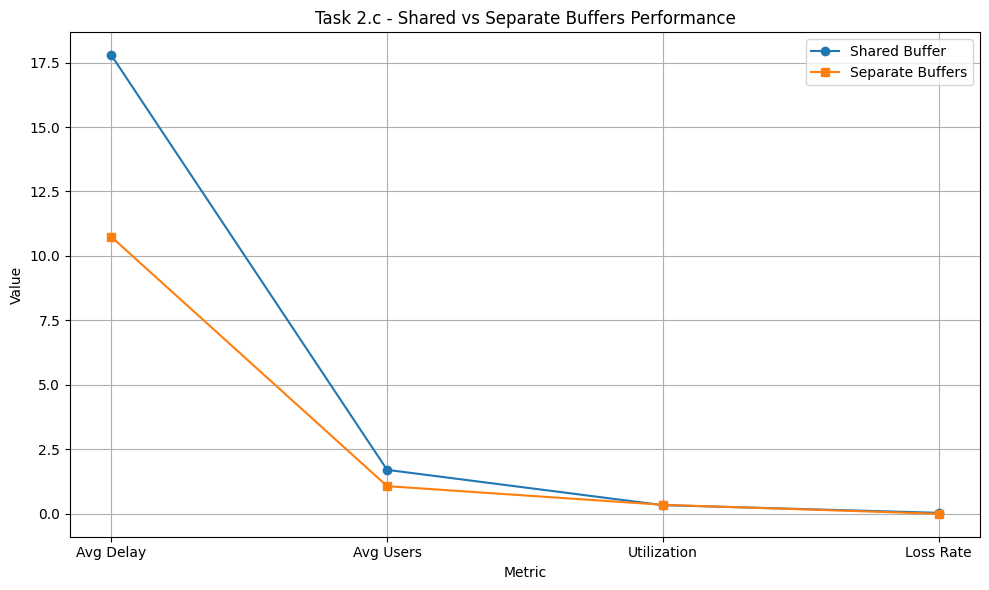

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(labels, shared, marker='o', label='Shared Buffer')
plt.plot(labels, separate, marker='s', label='Separate Buffers')
plt.title('Task 2.c - Shared vs Separate Buffers Performance')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
# Run both simulations
shared_results = simulate(shared=True)
separate_results = simulate(shared=False)

# Extract metrics
shared_delay, shared_avg_users, shared_utilization, shared_loss_rate = shared_results
separate_delay, separate_avg_users, separate_utilization, separate_loss_rate = separate_results




In [51]:
# Display metrics for shared queue
print("Metrics for Shared Queue:")
print(f"Average Delay: {shared_delay:.4f}")
print(f"Average Number of Users: {shared_avg_users:.4f}")
print(f"Utilization: {shared_utilization:.4f}")
print(f"Loss Rate: {shared_loss_rate:.4f}")
print()


Metrics for Shared Queue:
Average Delay: 17.7831
Average Number of Users: 1.7050
Utilization: 0.3357
Loss Rate: 0.0386



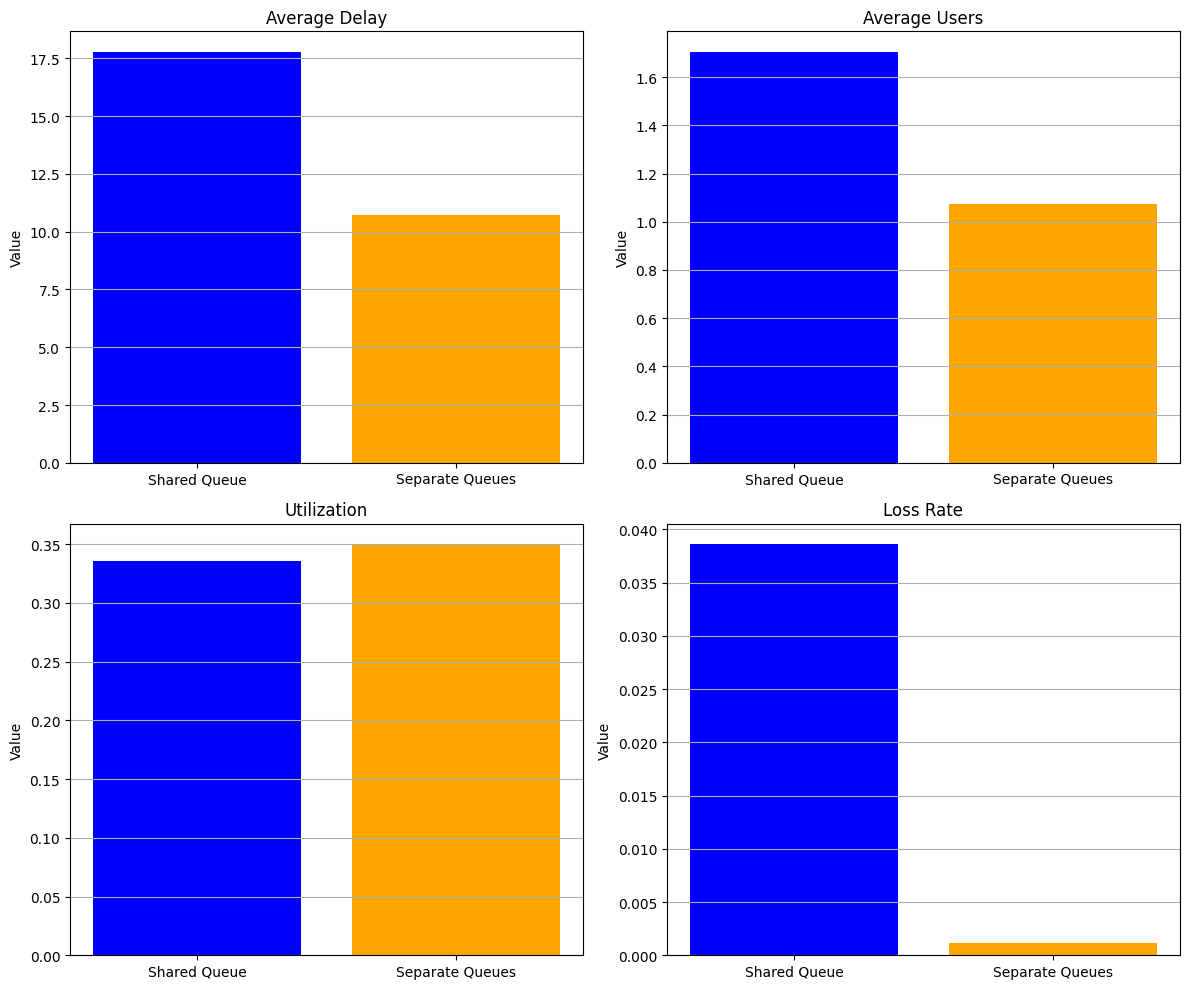

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

metrics = ['Average Delay', 'Average Users', 'Utilization', 'Loss Rate']
shared_metrics = [shared_delay, shared_avg_users, shared_utilization, shared_loss_rate]
separate_metrics = [separate_delay, separate_avg_users, separate_utilization, separate_loss_rate]

for i, ax in enumerate(axs.flat):
    ax.bar(['Shared Queue', 'Separate Queues'], [shared_metrics[i], separate_metrics[i]], color=['blue', 'orange'])
    ax.set_title(metrics[i])
    ax.set_ylabel('Value')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()